<a href="https://colab.research.google.com/github/blhuillier/2025B_AstroDataAnalysis/blob/main/Notebooks/Chap_4_Least_Squares_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Download data from:
2. Plot $mu(z)$
3. we want to transfomr $\mu$ to $d_L$.  
  a. Estimate $\sigma_{d_L}$ with Error propagation formula (Jacobian).  
  b. with MC.


In [1]:
filecov = "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov"
filemu = "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/refs/heads/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pan = pd.read_csv(filemu, sep=r'\s+') # delim_whitespace=True
# cov = pd.read_csv(filecov, delim_whitespace=True
cov = np.loadtxt(filecov)
nsn = int(cov[0])
cov = np.reshape(cov[1:],(nsn,nsn))
print (cov.shape)

# we remove some data:
id_to_cut = np.where((pan['zHD']<=0.01) | (pan['IS_CALIBRATOR']))[0]
# print (id_to_cut)

pan = pan.drop(id_to_cut)
cov = np.delete(cov, id_to_cut, axis=0)
cov = np.delete(cov, id_to_cut, axis=1)

# check if C is symmetric:
print (np.isclose(cov.T, cov).all())

# check if positive-definite:
print (np.linalg.eigvals(cov).min())



(1701, 1701)
True
0.005195877236093192


In [2]:
pan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1580 entries, 111 to 1700
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CID                   1580 non-null   object 
 1   IDSURVEY              1580 non-null   int64  
 2   zHD                   1580 non-null   float64
 3   zHDERR                1580 non-null   float64
 4   zCMB                  1580 non-null   float64
 5   zCMBERR               1580 non-null   float64
 6   zHEL                  1580 non-null   float64
 7   zHELERR               1580 non-null   float64
 8   m_b_corr              1580 non-null   float64
 9   m_b_corr_err_DIAG     1580 non-null   float64
 10  MU_SH0ES              1580 non-null   float64
 11  MU_SH0ES_ERR_DIAG     1580 non-null   float64
 12  CEPH_DIST             1580 non-null   float64
 13  IS_CALIBRATOR         1580 non-null   int64  
 14  USED_IN_SH0ES_HF      1580 non-null   int64  
 15  c                     15

<ErrorbarContainer object of 3 artists>

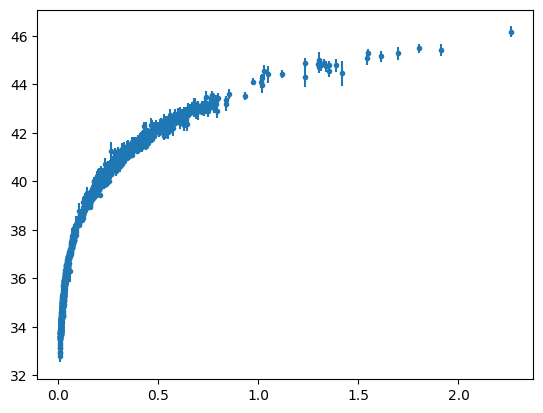

In [3]:
fig, ax = plt.subplots(1)
sigma_mu = np.sqrt(np.diag(cov))
ax.errorbar(pan['zHD'], pan['MU_SH0ES'], sigma_mu, ls='', marker='.')

In [4]:
mu = pan['MU_SH0ES'].values
dL = 10**(mu/5-5)
J = np.log(10)/5 * np.diag(dL)

cov_dL = J.T @ cov @ J

print (np.sqrt(np.diag(cov_dL)))


[   4.2367907     4.64805366    4.39683179 ... 1174.77630949 1453.2039315
 1684.08466893]


In [5]:
# MC:



#1. Generate mu_{MC,1}(z), mu_{MC,2}(z), ...., mu_{MC,N}(z) multivariate Gaussian distribution with
# expected value mu_th(z), covariance C_pantheon
NN = 10_000
r = np.random.RandomState(9238497)
epsilon = r.multivariate_normal(mean=np.zeros_like(mu), cov=cov,size=NN)
print (epsilon.shape)
mu_MC = mu + epsilon
dL_MC = 10**(mu_MC/5-5)
print (dL_MC.shape)




(10000, 1580)
(10000, 1580)


In [6]:
print (dL_MC.shape)
#2. Estimate Expected value [d_L]
print( f"E[d_L] = {dL_MC.mean(axis=0)}")
print (f" Observed dL={dL}")
#3. Estimate Cov(d_L)
cov_dL_MC = np.cov(dL_MC.T)
print (f"Cov(d_L)={cov_dL_MC}")
print (cov_dL_MC.shape)

print (cov_dL)


(10000, 1580)
E[d_L] = [   36.17428621    38.64813406    39.41940845 ... 12555.87434214
 12228.77673268 17319.91918117]
 Observed dL=[   35.96499465    38.33893106    39.21750856 ... 12511.22976922
 12152.34246852 17240.90266447]
Cov(d_L)=[[ 1.80460983e+01 -3.92566948e-01 -3.42791575e-01 ... -1.28604737e+02
  -1.90019884e+02 -1.43059406e+02]
 [-3.92566948e-01  2.19487269e+01  7.69227741e+00 ... -7.14227809e+01
   2.62423653e+02  3.04955827e+02]
 [-3.42791575e-01  7.69227741e+00  1.97729653e+01 ...  7.40084405e+01
   2.97218813e+02  5.35128438e+02]
 ...
 [-1.28604737e+02 -7.14227809e+01  7.40084405e+01 ...  1.38078479e+06
   1.66095092e+05  2.38726849e+05]
 [-1.90019884e+02  2.62423653e+02  2.97218813e+02 ...  1.66095092e+05
   2.14090322e+06  3.43960934e+05]
 [-1.43059406e+02  3.04955827e+02  5.35128438e+02 ...  2.38726849e+05
   3.43960934e+05  2.81562745e+06]]
(1580, 1580)
[[ 1.79503954e+01 -2.44293009e-01 -3.71643716e-01 ... -7.38471549e+01
  -7.03292193e+01 -8.36745320e+01]
 [-2.44

In [7]:
sigma_dL_MC = np.sqrt(np.diag(cov_dL_MC))
sigma_dL = np.sqrt(np.diag(cov_dL))
print (sigma_dL_MC / sigma_dL)

[1.00266222 1.00793734 1.01133736 ... 1.00024829 1.00686664 0.99637695]


In [8]:
print (sigma_dL / dL)

[0.11780318 0.12123587 0.112114   ... 0.09389775 0.11958221 0.09767961]


/tmp/ipython-input-636222642.py:3: RuntimeWarning: divide by zero encountered in divide
  im = ax.pcolormesh((cov_dL_MC/cov_dL))


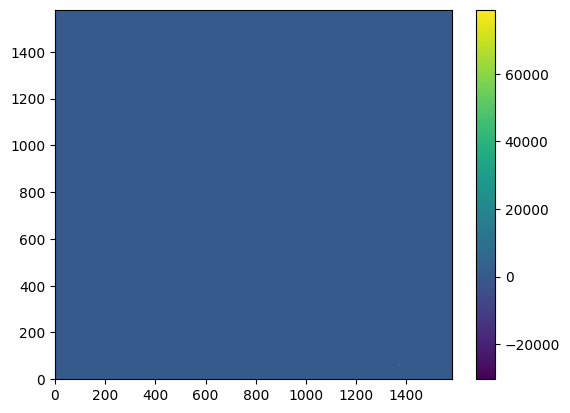

In [9]:
fig,ax = plt.subplots(1)

im = ax.pcolormesh((cov_dL_MC/cov_dL))
fig.colorbar(im)

Pandas is a useful python library to deal with data: Let's take a look at the tutorial:

https://pandas.pydata.org/docs/user_guide/10min.html



# Exercise I. Ordinary Least Squares

We want to model a system such that
$$Y = f(X) = a X^2 + b X + c,$$
where $(a,b,c)$ are the parameter of the model.

1. Write the system as an ordinary least square problem

2. Generate $N$ points for $X_i\sim  U(0,1)$

3. Set $(a,b,c) = (1,-2,3)$, and generate the corresponding $Y_i = f(X_i) + \varepsilon$,
where $\varepsilon \simeq {N}(0,0.5^2)$.

4. Overplot the true model and the realizations $(X_i,Y_i)$.

5. Calculate the OLS solution and find the best-fit parameters $(\hat a, \hat b, \hat c)$

6. use $\texttt{scipy.optimize}$ to find the (non-linear) Least Square Estimator, and compare with the linear case.  

7. Redo the same thing assuming $\epsilon\sim {N}(0,\mathop{\mathrm{diag}}(\sigma_i^2)$),
with $\sigma_i = 0.5 (1+X_i)$


# Exercise II. (From Feigelson & Babu)

1. Download the example QSO SDSS sample: https://astrostatistics.psu.edu/MSMA/datasets/SDSS_QSO.dat

2. You can use pandas to play with the data (I'll introduce it). The goal is to study the linear dependency of $z$-band on the $i$ band. It is not particularly physically interesting but at least you get to play with real data.

3. Select QSO with $18<i<22$ and fix values with $\sigma_z<0.01$ to 0.01. This prevents weird behaviours for abnormally small errors. You can also choose to remove QSO with $\sigma_z<0.01$.

4. Make a linear regression using the ordinary least square (ignore the errors in $z$.

5. Now let's consider the $z$-band error. Make a linear regression using the weighted least squares.



# Exercise III. (From Feidelson & Babu)

Fitting a Sersic Profile.
$$
\begin{align}
\mu(r) & = \mu_0 - 2.5 \log_{10} I(r)\\
\log_{10} I(r) & = \log_{10} I_e + b_n\left[\left(\frac r {r_e}\right)^{1/n}-1\right]\\
b_n & = -0.868n+0.142
\end{align}
$$
We can rewrite it as
$$
\begin{align}
\mu(r) = A-2.5 b_n\left[\left(\frac r {r_e}\right)^{1/n}-1\right]
\end{align}
$$


1. Download the NGC4472 data:  http://astrostatistics.psu.edu/MSMA/datasets/NGC4472_profile.dat

2. Plot the data

3. Plot the prediction $\mu(r;\theta)$ for different values of $\theta$. Calculate the corresponding
$$\chi^2 = \sum (\mu_i-\mu(r_i;A,n,r_e))^2$$

4. Plot $\chi^2(A=23,n,r_e)$

5. Fit the Sersic profile: find the non-linear least-square parameters

6. Plot the residuals

7. Same with http://astrostatistics.psu.edu/MSMA/datasets/NGC4406_profile.dat and http://astrostatistics.psu.edu/MSMA/datasets/NGC4551_profile.dat

